In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from matplotlib.animation import FuncAnimation
from scipy.spatial.distance import pdist
from IPython.display import HTML

In [2]:
# if you have difficulties with ffmpeg to run the simulation, see https://stackoverflow.com/questions/13316397/matplotlib-animation-no-moviewriters-available
# plt.rcParams['animation.ffmpeg_path'] = your_windows_path
plt.rcParams['animation.ffmpeg_args'] = '-report'
plt.rcParams['animation.bitrate'] = 2000

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
#from jupyterthemes import jtplot
#jtplot.style(theme='onedork', context='talk', fscale=1.4, spines=False, gridlines='--', ticks=True, grid=False, figsize=(8, 6))

### Load Iris Data

In [4]:
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [5]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

### Create DataFrame

In [6]:
features = iris.feature_names
data = pd.DataFrame(data=np.column_stack([iris.data, iris.target]), 
                    columns=features + ['label'])
data.label = data.label.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal length (cm)    150 non-null float64
sepal width (cm)     150 non-null float64
petal length (cm)    150 non-null float64
petal width (cm)     150 non-null float64
label                150 non-null int64
dtypes: float64(4), int64(1)
memory usage: 5.9 KB


### Standardize Data

Its important to do this when using clustering algorithms

In [7]:
scaler = StandardScaler()

#Note that features standardized is the name of our final dataset
features_standardized = scaler.fit_transform(data[features])
n = len(data)

### Reduce Dimensionality to visualize clusters

In [8]:
pca = PCA(n_components=2)
features_2D = pca.fit_transform(features_standardized)

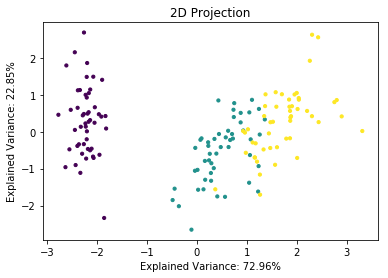

In [9]:
ev1, ev2 = pca.explained_variance_ratio_
ax = plt.figure().gca(title='2D Projection', 
                      xlabel='Explained Variance: {:.2%}'.format(ev1), 
                      ylabel='Explained Variance: {:.2%}'.format(ev2))
ax.scatter(*features_2D.T, c=data.label, s=10)

In [10]:
print(ev1+ev2)

0.9581320720000164


### Perform agglomerative clustering

Note that this is using scipy's clustering. There will be N-1 rows, each having 4 items

In [11]:
Z = linkage(features_standardized, 'ward')
Z[:5]

array([[1.01000000e+02, 1.42000000e+02, 0.00000000e+00, 2.00000000e+00],
       [7.00000000e+00, 3.90000000e+01, 1.21167870e-01, 2.00000000e+00],
       [1.00000000e+01, 4.80000000e+01, 1.21167870e-01, 2.00000000e+00],
       [9.00000000e+00, 3.40000000e+01, 1.31632184e-01, 2.00000000e+00],
       [0.00000000e+00, 1.70000000e+01, 1.31632184e-01, 2.00000000e+00]])

In [12]:
linkage_matrix = pd.DataFrame(data=Z, 
                              columns=['cluster_1', 'cluster_2', 
                                       'distance', 'n_objects'],
                              index=range(1, n))
for col in ['cluster_1', 'cluster_2', 'n_objects']:
    linkage_matrix[col] = linkage_matrix[col].astype(int)
linkage_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 1 to 149
Data columns (total 4 columns):
cluster_1    149 non-null int64
cluster_2    149 non-null int64
distance     149 non-null float64
n_objects    149 non-null int64
dtypes: float64(1), int64(3)
memory usage: 4.7 KB


In [13]:
linkage_matrix.head()

,cluster_1,cluster_2,distance,n_objects
1,101,142,0.00,2
2,7,39,0.12,2
3,10,48,0.12,2
4,9,34,0.13,2
5,0,17,0.13,2


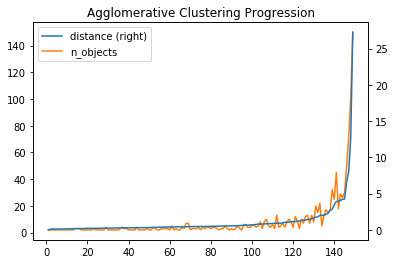

In [14]:
linkage_matrix[['distance', 'n_objects']].plot(secondary_y=['distance'], 
                        title='Agglomerative Clustering Progression');

### Compare linkage types

This is looking at the various methods and understanding the taxonomy that results

In [15]:
methods = ['single', 'complete', 'average', 'ward']
pairwise_distance = pdist(features_standardized)

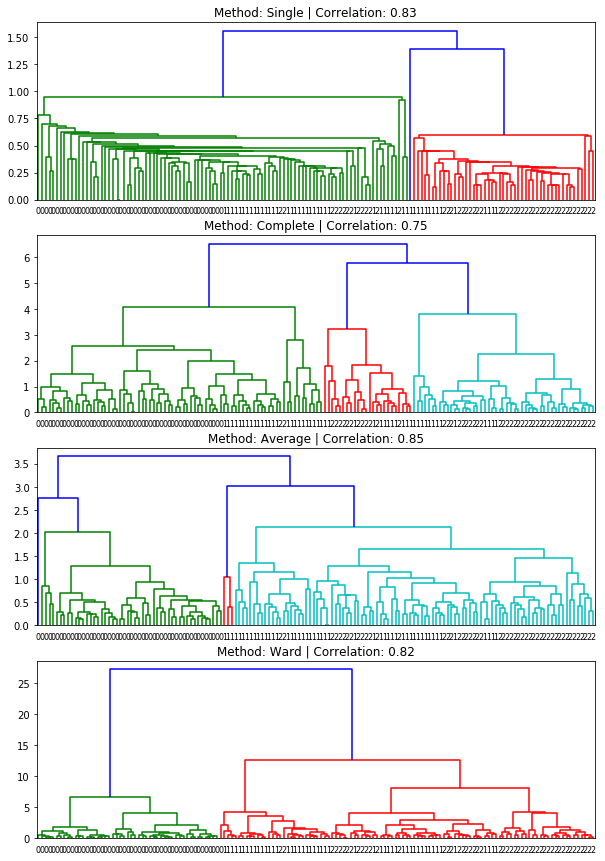

In [16]:
fig, axes = plt.subplots(figsize=(10, 15), nrows=4, sharex=True)
axes = axes.flatten()
for i, method in enumerate(methods):
    
    #Z is the output of the clustering proceedure
    Z = linkage(features_standardized, method)
    c, coph_dists = cophenet(Z, pairwise_distance)
    dendrogram(Z, labels=data.label.values,
        orientation='top', leaf_rotation=0., 
        leaf_font_size=8., ax = axes[i])
    axes[i].set_title('Method: {} | Correlation: {:.2f}'.format(
                                                method.capitalize(), c))


### Get Cluster Members

Which items were part of each merge?

In [17]:
n = len(Z)
from collections import OrderedDict
clusters = OrderedDict()

for i, row in enumerate(Z, 1):
    cluster = []
    for c in row[:2]:
        if c <= n:
            cluster.append(int(c))
        else:
            cluster += clusters[int(c)]
    clusters[n+i] = cluster

In [18]:
clusters[230]

[144, 124, 120, 143]

### Animate Agglomerative Clustering

Iterates over the items in the linkage matrix and merges them accoring to the growth of clusters from the
bottom up

In [19]:
def get_2D_coordinates():
    points = pd.DataFrame(features_2D).assign(n=1)
    return dict(enumerate(points.values.tolist()))

In [20]:
n_clusters = Z.shape[0]
points = get_2D_coordinates()
cluster_states = {0: get_2D_coordinates()}

for i, cluster in enumerate(Z[:, :2], 1):
    cluster_state = dict(cluster_states[i-1])
    merged_points = np.array([cluster_state.pop(c) for c in cluster])
    cluster_size = merged_points[:, 2]
    new_point = np.average(merged_points[:, :2], 
                           axis=0, weights=cluster_size).tolist()
    new_point.append(cluster_size.sum())
    cluster_state[n_clusters+i] = new_point
    cluster_states[i] = cluster_state

In [21]:
cluster_states[100]

{15: [-2.2622145316010216, 2.686284485110592, 1.0],
 41: [-1.8581224563735705, -2.3374151575533477, 1.0],
 60: [-0.11019628000062821, -2.6540728185365645, 1.0],
 62: [0.5621083064431791, -1.764724380616944, 1.0],
 106: [0.367017687860725, -1.561502891476507, 1.0],
 108: [2.0066864676766065, -0.7114386535471585, 1.0],
 109: [2.2597773490125004, 1.9210103764598856, 1.0],
 114: [1.4676452010173244, -0.44227158737708316, 1.0],
 176: [0.28711522075373147, -0.24204262329732373, 2.0],
 179: [-2.205821167298698, -0.0984455200835803, 2.0],
 185: [0.9688104990917797, 0.01907915384081517, 3.0],
 194: [0.7389335833626243, 0.6838170188840105, 2.0],
 197: [2.3691965862739504, 0.33967500639352866, 2.0],
 198: [-2.4657912495857985, -0.9936714816693261, 3.0],
 205: [1.9290326043911588, 0.5634757376107676, 3.0],
 206: [-1.930354657837599, 0.4980362956076003, 3.0],
 208: [-2.33244100242783, 0.10599232941089047, 3.0],
 209: [2.365628354573732, 2.5914923595139356, 2.0],
 210: [-2.375377894784248, -0.428476

### Set up Animation

In [22]:
%%capture
fig, ax = plt.subplots()
xmin, ymin = np.min(features_2D, axis=0) * 1.1
xmax, ymax = np.max(features_2D, axis=0) * 1.1
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

In [23]:
scat = ax.scatter([], [])
def animate(i):
    df = pd.DataFrame(cluster_states[i]).values.T
    scat.set_offsets(df[:, :2])
    scat.set_sizes((df[:, 2] * 2) ** 2)
    return scat,
    
anim = FuncAnimation(
    fig, animate, frames=cluster_states.keys(), interval=250, blit=False)
HTML(anim.to_html5_video())

### Scikit-Learn implementation

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


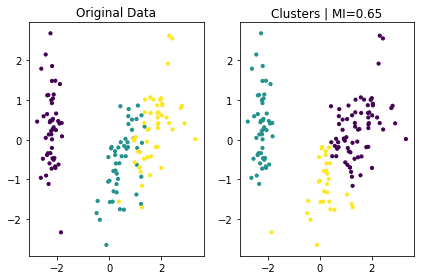

In [24]:
clusterer = AgglomerativeClustering(n_clusters=3)
data['clusters'] = clusterer.fit_predict(features_standardized)
fig, axes = plt.subplots(ncols=2)
labels, clusters = data.label, data.clusters
mi = adjusted_mutual_info_score(labels, clusters)
axes[0].scatter(*features_2D.T, c=data.label, s=10)
axes[0].set_title('Original Data')
axes[1].scatter(*features_2D.T, c=data.clusters, s=10)
axes[1].set_title('Clusters | MI={:.2f}'.format(mi))
plt.tight_layout()

### Comparing Mutual Information for different Linkage Options

Linkage method: ward


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


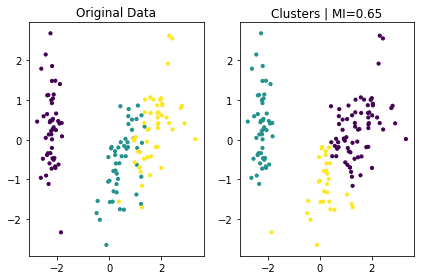

Linkage method: complete


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


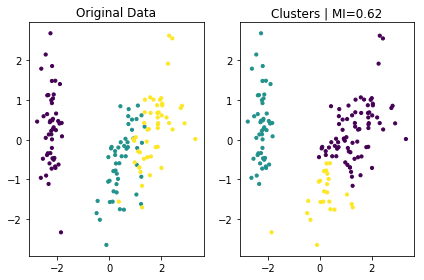

Linkage method: average


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


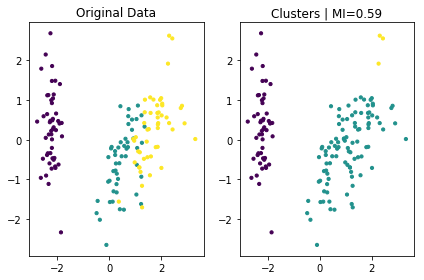

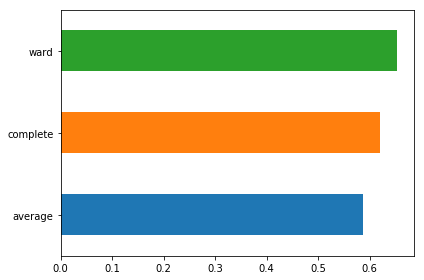

In [29]:
mutual_info = {}
for linkage_method in ['ward', 'complete', 'average']: 
    clusterer = AgglomerativeClustering(n_clusters=3, linkage=linkage_method)
    clusters = clusterer.fit_predict(features_standardized)  
    
    print(f'Linkage method: {linkage_method}')
    
    fig, axes = plt.subplots(ncols=2)
    labels = data.label
    mi = adjusted_mutual_info_score(labels, clusters)
    axes[0].scatter(*features_2D.T, c=data.label, s=10)
    axes[0].set_title('Original Data')
    axes[1].scatter(*features_2D.T, c=clusters, s=10)
    axes[1].set_title('Clusters | MI={:.2f}'.format(mi))
    plt.tight_layout()
    plt.show()
    
    
    mutual_info[linkage_method] = adjusted_mutual_info_score(clusters, labels)
fig, ax = plt.subplots()
pd.Series(mutual_info).sort_values().plot.barh()
plt.tight_layout()